In [192]:
import pandas as pd
import numpy as np
import pathlib
import os
import shutil

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

# General data loading for all experiments 

In [193]:
#Identify experiments that are not in the ignore list 
exp_test_description = "Full_Report"
directory = f"/h/kupfersk/cfpr_2025/generate_forecasts/output/"

ignore_list = [".csv",
               "ipynb",
#                 "llama",
#                 "gemini",
#                 "claude",
#                 "gpt",
#                "Mixtral",
               '5th',
               "restaurants",
               "DeepARModel_exp",
               "ChronosModel_exp",
               "PatchTSTModel_exp",
               "DLinearModel_exp",
               "exp7",
#                "exp8",
               "corr",
               "economic",
               "human",
#                "GPT_P",
#                "exp2_R"
#                "llm",
#                "exp1",
#                "report", 
#                "covariates",
               
]

experiments_include = []

for experiment_name in os.listdir(f"{directory}{'Full_Report'}"):
    if all(keyword not in experiment_name for keyword in ignore_list):
        experiments_include.append(experiment_name)

experiments_include

['ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_',
 'llama-3-70B_basic_desc_100_item',
 'ag_local_DeepARModel',
 'ag_global_all_SimpleFeedForwardModel_exp2_R4_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_R3_',
 'ag_global_all_SimpleFeedForwardModel_exp2_R1_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'gemini-1.5-pro_report_True_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
 'llama-3-70B_basic_desc_75_item',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'ag_local_AutoETSModel',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp8_',
 'llama-3-70B_basic_desc_100_prompt',
 'llama-3-70B_basic_desc_50_prompt',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'ag_glo

In [194]:

report_sim_dates = open("../generate_forecasts/experiment_cutoff_dates.txt", 'r').read().split()
# report_sim_dates = report_sim_dates[:1]


target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Dairy products and eggs',
     'Fish, seafood and other marine products',
#      'Food purchased from restaurants',
#      'Food',
     'Fruit, fruit preparations and nuts',
     'Meat',
     'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]

# llmp_target_categories = [
#     'Bakery and cereal products (excluding baby food)',
#      'Meat',
#      'Vegetables and vegetable preparations'
# ]


### Remove once it is finished running
# report_sim_dates= [report_sim_dates[0]]
# target_categories = target_categories[0:3]


target_categories = [f"food_cpi: {col}" for col in target_categories]

start_years = [1986]
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))


file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Dairy products and eggs
food_cpi: Fish, seafood and other marine products
food_cpi: Fruit, fruit preparations and nuts
food_cpi: Meat
food_cpi: Other food products and non-alcoholic beverages
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01
2023-07-01


### Ensure all necessary data is stored in Experimental_Analysis folder for easy access 

In [195]:
# # Define the source directory (starting from Full_Report)
# source_dir = "../generate_forecasts/output/Full_Report/"
# # No need to hard-code the destination directory here; it will be determined dynamically

# # Walk through the source directory to find the directories that contain '2024-07-01'
# for experiment in os.listdir(source_dir):
#     if experiment in experiments_include:
#         print(experiment)
        
#         for root, dirs, files in os.walk(f"/h/kupfersk/cfpr_2025/generate_forecasts/output/Full_Report/{experiment}"):
#             # Determine the destination directory dynamically by replacing 'Full_Report' with 'Forecasts'
#             new_dest = root.replace("Full_Report", "Experimental_Analysis")

#             # Ensure the destination directory exists, if not, create it
#             os.makedirs(new_dest, exist_ok=True)

#             # Move all files from the current 'root' to the new destination directory
#             for file in files:
#                 if '.csv' in file:
#                     source_file = os.path.join(root, file)
#                     dest_file = os.path.join(new_dest, file)
#                     shutil.copy2(source_file, dest_file)  # Use shutil.move() to move files
#                     print(f"Moved {source_file} to {dest_file}")


### Define evaluation metrics and calculate mape for all periods

In [196]:
# Define the source directory (starting from Full_Report)
source_dir = "../generate_forecasts/output/Experimental_Analysis/"
experiments = experiments_include
experiments

['ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_',
 'llama-3-70B_basic_desc_100_item',
 'ag_local_DeepARModel',
 'ag_global_all_SimpleFeedForwardModel_exp2_R4_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_R3_',
 'ag_global_all_SimpleFeedForwardModel_exp2_R1_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'gemini-1.5-pro_report_True_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
 'llama-3-70B_basic_desc_75_item',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'ag_local_AutoETSModel',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp8_',
 'llama-3-70B_basic_desc_100_prompt',
 'llama-3-70B_basic_desc_50_prompt',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'ag_glo

In [197]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [198]:
import json


def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df
    global actual_df
    global predicted_categories
    
    results = []
    
        
#     # Load the dictionary from the JSON file
#     with open('target_category_dict_filt.json', 'r') as json_file:
#         target_category_dict = json.load(json_file)
        
    for start_year in start_years:
        for EXPERIMENT_NAME in experiments:
            predicted_categories = []
            
            print(EXPERIMENT_NAME)
            if 'ag' in EXPERIMENT_NAME :
                predicted_categories = target_categories
#                 if "R" not in EXPERIMENT_NAME:
#                     if 'exp' in EXPERIMENT_NAME: 
#                         general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
#                         predicted_categories_in = target_category_dict[general_experiment]

                        # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
#                         predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']


            for category in predicted_categories:
                if "restaurant" in category:
                    continue 
                    
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]
                    
                    if report_sim_dates[-1] == cutoff_date:
                        forecast_df = forecast_df.iloc[:-1]
                        actual_df = actual_df.iloc[:-1]


                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)


In [199]:
with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
    target_category_dict = json.load(json_file)
    
target_category_dict

{'exp5_geopolitical_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_manufacturing_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_climate_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi

In [200]:
## For classical model experiments 
mape_df = compute_all_scores(report_sim_dates, "mape")
mape_df

# mape_df['path']= "f'./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_42/{cutoff_date}/forecasts/{category}.csv'"
mape_df.experiment.unique()


ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_
llama-3-70B_basic_desc_100_item
ag_local_DeepARModel
ag_global_all_SimpleFeedForwardModel_exp2_R4_
ag_global_all_TemporalFusionTransformerModel_exp2_R3_
ag_global_all_SimpleFeedForwardModel_exp2_R1_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel
gemini-1.5-pro_report_True_with_future_forecasts_True
ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_
llama-3-70B_basic_desc_75_item
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_
ag_local_AutoETSModel
gemini-1.5-pro_report_False_with_future_forecasts_True
ag_global_all_SimpleFeedForwardModel_exp8_
llama-3-70B_basic_desc_100_prompt
llama-3-70B_basic_desc_50_prompt
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_
ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_
claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_
ag_g

array(['ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_',
       'ag_local_DeepARModel',
       'ag_global_all_SimpleFeedForwardModel_exp2_R4_',
       'ag_global_all_TemporalFusionTransformerModel_exp2_R3_',
       'ag_global_all_SimpleFeedForwardModel_exp2_R1_',
       'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
       'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
       'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
       'ag_local_AutoETSModel',
       'ag_global_all_SimpleFeedForwardModel_exp8_',
       'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
       'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_',
       'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_geopolitical_',
       'ag_global_all_PatchTSTModel',
       'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_manufacturing_',
       'ag_global_all_TemporalFusionTransformerMod

# Figure 3. How much more often did global models end up in the top when we used curated variables


Steps:
1) load in all data
2) Do this for TemporalFusionTransformer
3) Repeat for global all and global+covariates 


In [205]:
def assign_condition(experiment):
    experiment = experiment.lower()  # Make lowercase for case-insensitive matching
    if 'covariates' in experiment:
        return 'covariates'
    
    elif 'local' in experiment:
        return 'local'
    
    elif 'global' in experiment:
        return 'global'   
    
    else:
        return 'all'  # Default to 'all' if none of the keywords are found

# Define the function to assign model class based on keywords in experiment names
def assign_class(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'transformer' in experiment or 'tst' in experiment: 
        return 'Transformer'

    # Check for LLM models (Chronos in this case)
    elif 'chronos' in experiment:
        return 'Foundation'

    # Check for general deep learning models
    elif 'global' in experiment:
        return 'Deep Learning'

    # Check for statistical models
    elif 'autoets' in experiment or 'arima' in experiment or 'naive' in experiment:
        return 'Statistical'

    # Default to 'Deep Learning' if no keywords match
    else:
        return 'Deep Learning'
    
    
def assign_curation(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'exp1' in experiment: 
        return 'Selected by LLM'
    
    # Check for LLM models (Chronos in this case)
    elif 'exp5' in experiment:
        return 'Selected by expert defined categories'
    
    # Check for global models
    elif 'global' in experiment:
        return 'global'

    # Check for local models
    elif 'local' in experiment:
        return 'local'


    
def assign_model(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'transformer' in experiment:
        return 'TemporalFusionTransformer'
    
    elif 'transformer' in experiment and 'global' in experiment:
        return 'TemporalFusionTransformer with covariates'
    
    # Check for LLM models (Chronos in this case)
    elif 'tst' in experiment:
        return 'PatchTST'

    # Check for LLM models (Chronos in this case)
    elif 'deepar' in experiment:
        return 'DeepAR'

    # Check for general deep learning models
    elif 'simple' in experiment:
        return 'SimpleFeedForwardNetwork'
    
    # Check for general deep learning models
    elif 'linear' in experiment:
        return 'DLinear'
    
    # Check for general deep learning models
    elif 'chronos' in experiment:
        return 'Chronos'

    # Check for statistical models
    elif 'ets' in experiment:
        return 'Exponential smoothing'
    
    # Check for statistical models
    elif 'arima' in experiment:
        return 'ARIMA'
    
    # Check for statistical models
    elif 'naive' in experiment:
        return 'Naive'

    # Default to 'Deep Learning' if no keywords match
    else:
        return 'Other'


def assign_selection(experiment):
    experiment = experiment.lower()  # Convert to lowercase for case-insensitive matching

    # Check for Transformer models first to avoid overlap with "Deep Learning"
    if 'exp2_r' in experiment:
        return 'Baseline - Random average (n=5)'
    
   # Check for LLM models (Chronos in this case)
    elif 'gpt_p1' in experiment:
        return 'LLM persona - Global affairs speciallist'

    # Check for LLM models (Chronos in this case)
    elif 'gpt_p2' in experiment:
        return 'LLM persona - Economist'

    # Check for general deep learning models
    elif 'gpt_p3' in experiment:
        return 'LLM persona - Agronomist'
    
    # Check for general deep learning models
    elif 'gpt_p4' in experiment:
        return 'LLM persona - average Canadian'
    
    # Check for general deep learning models
    elif 'chronosmodel' in experiment:
        return 'Baseline - Foundation zero-shot'

    # Check for statistical models
    elif 'exp8_' in experiment:
        return 'Baseline - Correlation by category'
    
    # Check for statistical models
    elif 'exp1_' in experiment:
        return 'LLM concenus - across all personas'  
    
    
    
# Apply the function to add a new column 'condition' in filt_df
mape_df['condition'] = mape_df['experiment'].apply(assign_condition)
mape_df['class'] = mape_df['experiment'].apply(assign_class)
mape_df['model_name'] = mape_df['experiment'].apply(assign_model)
mape_df['curated'] = mape_df['experiment'].apply(assign_curation)
mape_df['selection'] = mape_df['experiment'].apply(assign_selection)


mape_df['selection'].unique()
mape_df = mape_df.sort_values(by="selection")
mape_df['model_name'].unique()


array(['TemporalFusionTransformer', 'SimpleFeedForwardNetwork', 'Chronos',
       'DeepAR', 'Exponential smoothing', 'PatchTST', 'ARIMA', 'Naive',
       'DLinear'], dtype=object)

In [218]:
## I need to filter so that I am only comparing TemporalFusionTransformer and SimpleFeedForwardNetwork with global setups

filtered_df = mape_df[
    (mape_df['model_name'].isin(['TemporalFusionTransformer'])) &
    (mape_df['condition'].isin(['global']))]
     
mape_df = filtered_df

In [219]:
mape_df['model_name'].unique()


array(['TemporalFusionTransformer'], dtype=object)

In [232]:
mape_df

,year,experiment,category,mean_score,std_score,scores,condition,class,model_name,curated,selection
303,1986,ag_global_all_TemporalFusionTransformerModel_e...,"food_cpi: Fish, seafood and other marine products",0.021010,0.016883,"[0.007666240377101842, 0.01566790596957809, 0....",global,Transformer,TemporalFusionTransformer,global,Baseline - Correlation by category
307,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Vegetables and vegetable preparations,0.053971,0.017956,"[0.0733729879665628, 0.03854287398459602, 0.06...",global,Transformer,TemporalFusionTransformer,global,Baseline - Correlation by category
302,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Dairy products and eggs,0.027436,0.015038,"[0.01330388961766621, 0.02444603253652021, 0.0...",global,Transformer,TemporalFusionTransformer,global,Baseline - Correlation by category
306,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Other food products and non-alcoholi...,0.035183,0.029536,"[0.007744938160355029, 0.021488460039667086, 0...",global,Transformer,TemporalFusionTransformer,global,Baseline - Correlation by category
301,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Bakery and cereal products (excludin...,0.041331,0.038299,"[0.015471971893425966, 0.015239076516441987, 0...",global,Transformer,TemporalFusionTransformer,global,Baseline - Correlation by category
...,...,...,...,...,...,...,...,...,...,...,...
254,1986,ag_global_all_TemporalFusionTransformerModel_e...,"food_cpi: Fish, seafood and other marine products",0.019200,0.014650,"[0.009935337609374829, 0.011238837311825078, 0...",global,Transformer,TemporalFusionTransformer,Selected by expert defined categories,None
255,1986,ag_global_all_TemporalFusionTransformerModel_e...,"food_cpi: Fruit, fruit preparations and nuts",0.027372,0.019755,"[0.018481534354347576, 0.02011504200623008, 0....",global,Transformer,TemporalFusionTransformer,Selected by expert defined categories,None
256,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Meat,0.026253,0.010224,"[0.013257525886088282, 0.020329356922154096, 0...",global,Transformer,TemporalFusionTransformer,Selected by expert defined categories,None
257,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Other food products and non-alcoholi...,0.030659,0.027934,"[0.00669348429856759, 0.013435605148641295, 0....",global,Transformer,TemporalFusionTransformer,Selected by expert defined categories,None


### Averaged across all categories

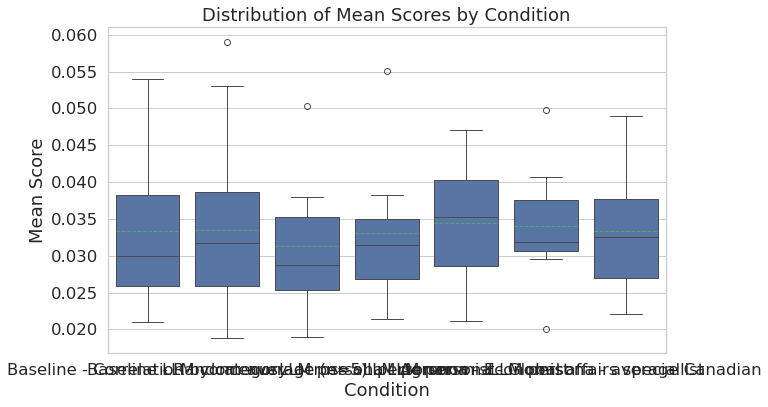

In [220]:
# What if we aggregate across all of the food categories
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Create a boxplot to show the distribution of mean_score across conditions
plt.figure(figsize=(10, 6))
sns.boxplot(data=mape_df, x='selection', y='mean_score', showmeans=True, meanline=True)

# Add plot labels and title
plt.title("Distribution of Mean Scores by Condition")
plt.xlabel("Condition")
plt.ylabel("Mean Score")

# Show plot
plt.show()

/tmp/ipykernel_28909/1538086113.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=mape_df, x='selection', y='mean_score', showmeans=True, meanline=True, palette=gradient_palette)


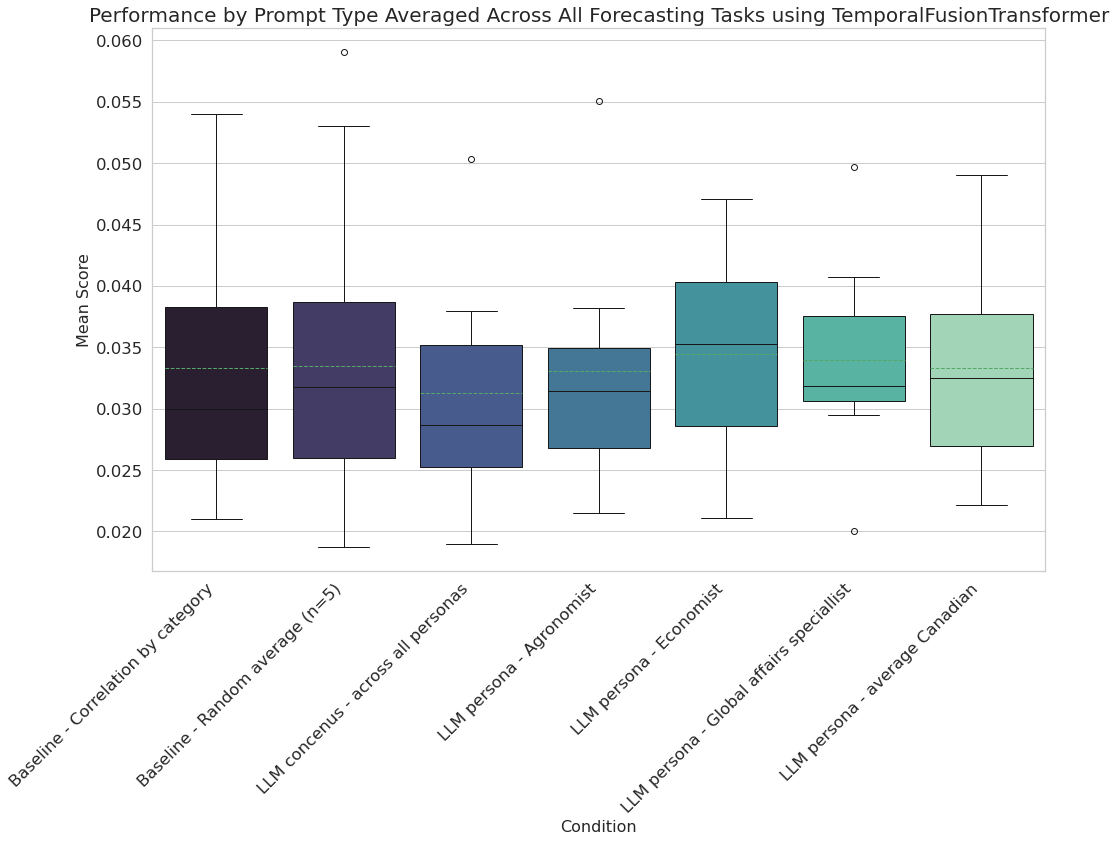

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up Seaborn with a purple color palette, larger font sizes, and context adjustments
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)
gradient_palette = sns.color_palette("mako", n_colors=mape_df['selection'].nunique())

# Create a larger boxplot to show the distribution of mean_score across conditions
plt.figure(figsize=(16, 10))  # Increase figure size for more space between plots
sns.boxplot(data=mape_df, x='selection', y='mean_score', showmeans=True, meanline=True, palette=gradient_palette)

# Customize plot labels and title with larger font sizes
plt.title("Performance by Prompt Type Averaged Across All Forecasting Tasks using TemporalFusionTransformer", fontsize=20)
plt.xlabel("Condition", fontsize=16)
plt.ylabel("Mean Score", fontsize=16)

# Set y-axis limits to exclude extreme outliers and make the plots more readable

# Rotate x-axis labels if needed to prevent overlap
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()


### By individiual food category

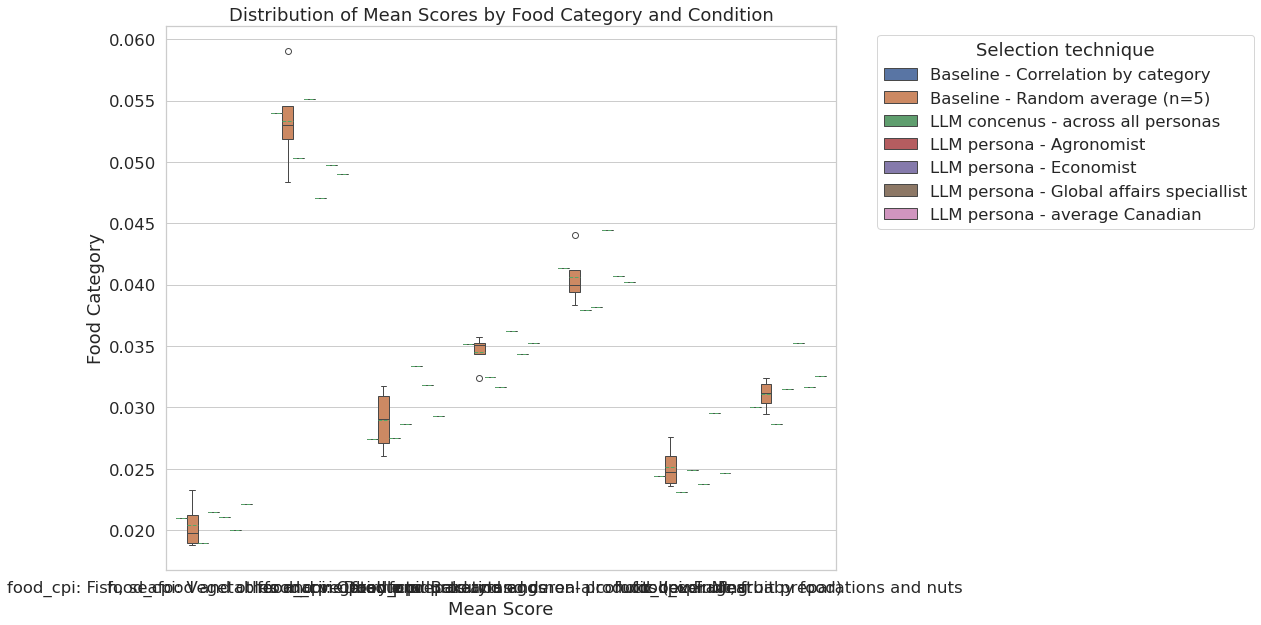

In [228]:

# Set up the plot with category on the y-axis, mean_score on the x-axis, and hue for conditions
plt.figure(figsize=(12, 10))
sns.boxplot(data=mape_df, y='mean_score', x='category', hue='selection', showmeans=True, meanline=True)

# Add plot labels and title
plt.title("Distribution of Mean Scores by Food Category and Condition")
plt.xlabel("Mean Score")
plt.ylabel("Food Category")

# Show plot with legend outside
plt.legend(title='Selection technique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [231]:
# Step 1: Aggregate mean and standard deviation
summary_table = mape_df.groupby(['category', 'selection']).agg(
    Mean_Score=('mean_score', 'mean'),
    Std_Deviation=('std_score', 'mean')
).reset_index()

# Step 2: Format the results as "mean ± std"
summary_table['Mean_Std'] = summary_table.apply(
    lambda row: f"{row['Mean_Score']:.3f} ± {row['Std_Deviation']:.3f}", axis=1
)

# Step 3: Pivot the table to have each condition as a column
pivot_table = summary_table.pivot(index='category', columns='selection', values='Mean_Std').reset_index()

# Display the pivoted summary table
pivot_table.set_index('category')

selection,Baseline - Correlation by category,Baseline - Random average (n=5),LLM concenus - across all personas,LLM persona - Agronomist,LLM persona - Economist,LLM persona - Global affairs speciallist,LLM persona - average Canadian
category,,,,,,,
food_cpi: Bakery and cereal products (excluding baby food),0.041 ± 0.038,0.041 ± 0.036,0.038 ± 0.033,0.038 ± 0.036,0.044 ± 0.036,0.041 ± 0.036,0.040 ± 0.039
food_cpi: Dairy products and eggs,0.027 ± 0.015,0.029 ± 0.014,0.027 ± 0.016,0.029 ± 0.015,0.033 ± 0.011,0.032 ± 0.013,0.029 ± 0.013
"food_cpi: Fish, seafood and other marine products",0.021 ± 0.017,0.020 ± 0.014,0.019 ± 0.014,0.021 ± 0.017,0.021 ± 0.017,0.020 ± 0.016,0.022 ± 0.016
"food_cpi: Fruit, fruit preparations and nuts",0.030 ± 0.020,0.031 ± 0.020,0.029 ± 0.019,0.031 ± 0.021,0.035 ± 0.019,0.032 ± 0.022,0.033 ± 0.016
food_cpi: Meat,0.024 ± 0.015,0.025 ± 0.010,0.023 ± 0.009,0.025 ± 0.012,0.024 ± 0.009,0.030 ± 0.014,0.025 ± 0.007
food_cpi: Other food products and non-alcoholic beverages,0.035 ± 0.030,0.035 ± 0.030,0.032 ± 0.029,0.032 ± 0.027,0.036 ± 0.028,0.034 ± 0.030,0.035 ± 0.031
food_cpi: Vegetables and vegetable preparations,0.054 ± 0.018,0.053 ± 0.022,0.050 ± 0.016,0.055 ± 0.023,0.047 ± 0.022,0.050 ± 0.020,0.049 ± 0.019
